# BeakerX with Spark, HDFS, and UI Tools

Notebooks are great for quick iterative data science work. Working with large datasets, however, can sometimes be challenging, since data is typically loaded and manipulated in the browser.<br>
Switching to pyspark is a good option, but you still lose many of the helpful tools available in regular Python.<br>
With BeakerX you can efficiently work with large datasets using Spark and still use many of Python libraries (e.g., scikit learn). 
In this notebook, we will demonstrate working with BeakerX UI's and use BeakerX to move data between different types of Kernels. 

This notebook assumes that Spark and HDFS is installed on the DC/OS cluster using the default settings. Directions for installing HDFS and Spark can be found in these videos:<br>
https://www.youtube.com/watch?v=PRgJsGwfIDk
https://www.youtube.com/watch?v=5vvnNxCjdFM

It also assumes that you've done the following in a Jupyter terminal.

Open this notebook in Jupyterlab and run from there.

### Using a UI to select a sample size
This is one simple example of many UI's available in BeakerX<br>

In [1]:
%%groovy
import com.twosigma.beakerx.widget.IntSlider

sample_size = new IntSlider()
sample_size.min = 100
sample_size.max = 10000
sample_size.step = 100
sample_size.value = 5000
sample_size

We can see the value has been set in the Groovy kernel.

In [2]:
%%groovy
beakerx.sample_size = sample_size.value

10000

It is also available in the Scala Kernel. This works in both directions.

In [3]:
beakerx.sample_size

10000

It is also available in other kernels. Here is a python example.

In [4]:
%%python
from beakerx.object import beakerx
beakerx.sample_size

10000

Moving variables and data from kernel to kernel can greatly simplify code. It makes it easier to use the best tools for a specific job. 

We'll use the sample size given above to generate a small set of records and load them into HDFS.

In [5]:
import sys.process._
val runme = "./generate_example.py somedata " + beakerx.sample_size
runme !

0

### Loading class
Many of the most used Java classes are stored locally so you won't need to find and download them.

In [6]:
%classpath add jar /mnt/mesos/sandbox
%classpath add jar /opt/spark/jars/*
%classpath add jar /opt/hadoop/share/hadoop/common/*
%classpath add jar /opt/hadoop/share/hadoop/common/lib/*
%classpath add jar /opt/hadoop/share/hadoop/hdfs/*
%classpath add jar /opt/hadoop/share/hadoop/hdfs/lib/*
%classpath add jar /opt/hadoop/share/hadoop/yarn/*
%classpath add jar /opt/hadoop/share/hadoop/yarn/lib/*
%classpath add jar /opt/hadoop/share/hadoop/mapreduce/*
%classpath add jar /opt/hadoop/share/hadoop/mapreduce/lib/*
%classpath add jar /opt/hadoop/share/hadoop/tools/lib/*

### Use a GUI to connect to Spark
#### These are the settings if we used code to connect to spark.
Note that the settings do not require finding node ip's, etc.<br>
The master url is the default for DC/OS.<br>

#### We will use the GUI instead of code.
One advantage of using the UI versus code is there are GUI metrics provided. <br>
It also allows you easily create, save, and select mulpiple connections strings. <br>
Run start and make selections that match the above. Delete entries that do not match.

In [7]:
%%spark

Load the spark libraries

In [8]:
import org.apache.spark.ml.Pipeline
import org.apache.spark.ml.evaluation.RegressionEvaluator
import org.apache.spark.ml.feature.{StringIndexer, VectorAssembler}
import org.apache.spark.ml.regression.GBTRegressor
import org.apache.spark.sql.types.{DoubleType, StringType, StructField, StructType, IntegerType}
import org.apache.spark.sql.{Encoders, SparkSession}
import org.apache.spark.ml.classification.LogisticRegression
import scala.math.{ pow, sqrt }

import org.apache.spark.ml.Pipeline
import org.apache.spark.ml.evaluation.RegressionEvaluator
import org.apache.spark.ml.feature.{StringIndexer, VectorAssembler}
import org.apache.spark.ml.regression.GBTRegressor
import org.apache.spark.sql.types.{DoubleType, StringType, StructField, StructType, IntegerType}
import org.apache.spark.sql.{Encoders, SparkSession}
import org.apache.spark.ml.classification.LogisticRegression
import scala.math.{pow, sqrt}


Load data from HDFS that was generated by the above code.

In [9]:
// Create a schema
val schemaStruct = StructType(
  StructField("x1", DoubleType) ::
  StructField("x2", DoubleType) ::
  StructField("y", IntegerType) :: Nil
  )

// Use schema to read data from hdfs using default url
val df = spark.read
  .option("header", true)
  .schema(schemaStruct)
  .csv("hdfs://name-0-node.hdfs.autoip.dcos.thisdcos.directory:9001/somedata.csv")
  .na.drop()

Display the results with a table view. Click on the ellipses in the column headers for filter, sorting, and other options.

In [10]:
df.display()

Run a logistic regression and get results.

In [11]:
// Break data into training and test
val Array(trainingData, testData) = df.randomSplit(Array(0.8, 0.2))
val labelColumn = "y"

// Use the VectorAssembler to combine the x1, x2 columns into a single vector column
val assembler = new VectorAssembler()
  .setInputCols(Array("x1", "x2"))
  .setOutputCol("features")

// logistic regression model
val lr = new LogisticRegression()
  .setLabelCol(labelColumn)
  .setFeaturesCol("features")
  .setPredictionCol("Predicted" + labelColumn)
  .setMaxIter(100)
  .setRegParam(0.1)
  .setElasticNetParam(0.8)

// Run simple pipeline
val stages = Array(assembler, lr)
val pipeline = new Pipeline().setStages(stages)
val model = pipeline.fit(trainingData)

//We'll make predictions using the model and the test data and get accuracy
val predictions = model.transform(testData)
predictions.filter("y == Predictedy").count()/predictions.count().toDouble

0.4891625615763547

### Prep data and plot

In [12]:
// Create function to remove dimentionality of a list
def flatten(l: List[Any]): List[Any] = {
    def _flatten(res: List[Any], rem: List[Any]):List[Any] = rem match {
        case Nil => res
        case (h:List[_])::Nil => _flatten(res, h)
        case (h:List[_])::tail => _flatten(res:::h, tail)
        case h::tail => _flatten(res:::List(h), tail)
    }
    _flatten(List(), l)
}

// Split positive and negative cases
val dfPOS = df.filter("y == 1")
val dfNEG = df.filter("y == 0")

// Plot the first 300 records of positve and negative cases
val plotPOSx1 = flatten(dfPOS.select("x1").collect().map(_ (0)).toList).map(_.toString.toDouble)
val plotPOSx2 = flatten(dfPOS.select("x2").collect().map(_ (0)).toList).map(_.toString.toDouble)
val plotNEGx1 = flatten(dfNEG.select("x1").collect().map(_ (0)).toList).map(_.toString.toDouble)
val plotNEGx2 = flatten(dfNEG.select("x2").collect().map(_ (0)).toList).map(_.toString.toDouble)

println(" ")

val plot = new Plot { title = "Plot of raw data" }

val list = List(
    new Points {
        x = plotPOSx1.take(300)
        y = plotPOSx2.take(300)
        size = 5.0
        color = Color.red
    },
    new Points {
        x = plotNEGx1.take(300)
        y = plotNEGx2.take(300)
        size = 5.0
        color = Color.blue
    }
)

plot.add(list)

Easy to see why a linear partition won't split the positive and negative cases.<br>
Using the Pythagorean Theorem $ a^2 + b^2 = c^2 $ we can map the data into something we can linearly split.

In [13]:
// Transform data and replot
val ax1 = plotPOSx1.take(300).map(pow(_,2))
val ax2 = plotPOSx2.take(300).map(pow(_,2))
val bx1 = plotNEGx1.take(300).map(pow(_,2))
val bx2 = plotNEGx2.take(300).map(pow(_,2))
val plot = new Plot { title = "Plot of data with features quared" }

val list = List(
    new Points {
        x = ax1
        y = ax2
        size = 5.0
        color = Color.red
    },
    new Points {
        x = bx1
        y = bx2
        size = 5.0
        color = Color.blue
    }
)

plot.add(list)

This should be easy for a logistic regression to classify.

Redo the model with the transformed data.

In [14]:
// w1 = x1^2, w2 = x2^2
val dfT = df.withColumn("w1", ((df.col("x1")*df.col("x1")))).withColumn("w2", ((df.col("x2")*df.col("x2"))))
val Array(trainingData, testData) = dfT.randomSplit(Array(0.8, 0.2))
val labelColumn = "y"

// Use the VectorAssembler to combine the w1, w2 columns into a single vector column
val assembler = new VectorAssembler()
  .setInputCols(Array("w1", "w2"))
  .setOutputCol("features")

// logistic regression model used above
val lr = new LogisticRegression()
  .setLabelCol(labelColumn)
  .setFeaturesCol("features")
  .setPredictionCol("Predicted" + labelColumn)
  .setMaxIter(100)
  .setRegParam(0.1)
  .setElasticNetParam(0.8)

// Same pipeline as above
val stages = Array(assembler, lr)
val pipeline = new Pipeline().setStages(stages)
val model = pipeline.fit(trainingData)

//We'll make predictions using the model and the test data
val predictions = model.transform(testData)
predictions.filter("y == Predictedy").count()/predictions.count().toDouble

0.9719016557952835

As expected the model works much better. Accuracy is only one useful metric. An easy way to create a confusion matrix is in scikit learn.<br>
We can pass the data to beakerx and use it in python.

In [15]:
val evalData = predictions.select("y", "Predictedy").head(predictions.count().toInt)
beakerx.evalData = evalData
println("Data moved to BeakerX")

Data moved to BeakerX


null

Now the data is accessable to python and scikit learn.

In [16]:
%%python
from beakerx.object import beakerx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

dfEval = pd.DataFrame(' '.join(beakerx.evalData).replace('[','').replace(']','').split())[0].str.split(',', expand = True)
cm = confusion_matrix(pd.to_numeric(dfEval[0], downcast='integer'),pd.to_numeric(dfEval[1], downcast='integer'))
cm

array([[971,  36],
       [ 20, 966]])

Or plot the confusion matrix<br>
This is an example of using sklearn libraries for models that where created and run in spark.

Text(0.5, 1.0, 'Confusion Matrix')

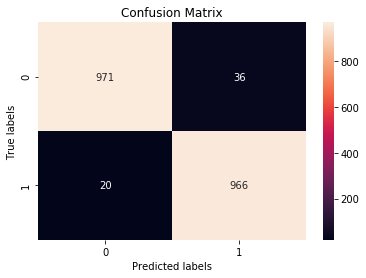

In [17]:
%%python
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

From here we can easy get Precision, Recall, and f1.